Notebook for the data augmentation of dataset of L. Leprince, located in data/3DSyntheticForm/txt/ and data/3DSyntheticForm/txt_angular/. 

In [1]:
import modules.MainFunctions as MF
import matplotlib.pyplot as plt
import numpy as np
from time import time
from tqdm import tqdm # For loading bars
import os

file_number=1

%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
dir_path = "data/3DSyntheticForm/txt/"
files = os.listdir(dir_path)
Nf =len(files)
N = 46
Lmax = 18

In [3]:
# We load the a big RY matrix to make the decompositions and reconstructions faster.
big_RY = MF.find_RY(N,Lmax)

Loading data/precomputedRY/RY_M_100_Lmax_18_.npy


In [4]:
# loading the 135 forms from data/3DSyntheticForm/txt/ and saving them in data/3DGeneratedForms/
for n in tqdm(range(Nf),desc="Work in progress"):

    path = dir_path+files[n]
    original_shape,N,b = MF.get_object_param(path)
    
    np.save("data/3DGeneratedForms/form_"+str(n+1)+"_",original_shape)
    
    # Decomposition
    cr = MF.decompose(path,Lmax,big_RY)
    
    pathSpec = "data/3DGeneratedSpectra/spec_"+str(n+1)+"_"
    np.save(pathSpec, cr)

Work in progress:  70%|████████████████████████████████████████████▎                  | 95/135 [01:31<00:30,  1.30it/s]

Work in progress: 100%|██████████████████████████████████████████████████████████████| 135/135 [02:07<00:00,  1.06it/s]


In [26]:
# loading the 125 forms from data/3DSyntheticForm/txt_angular/ and saving them in data/3DGeneratedForms/
dir_path = "data/3DSyntheticForm/txt_angular/"
files = os.listdir(dir_path)
Nf =len(files)

for n in tqdm(range(Nf),desc="Work in progress"):

    path = dir_path+files[n]
    original_shape,N,b = MF.get_object_param(path)
    
    np.save("data/3DGeneratedForms/form_"+str(135+n+1)+"_",original_shape)
    
    # Decomposition
    cr = MF.decompose(path,Lmax,big_RY)
    
    pathSpec = "data/3DGeneratedSpectra/spec_"+str(135+n+1)+"_"
    np.save(pathSpec, cr)

Work in progress:   4%|██▌                                                             | 5/125 [00:03<01:17,  1.54it/s]

Work in progress:  82%|███████████████████████████████████████████████████           | 103/125 [01:17<00:15,  1.45it/s]

Work in progress:  83%|███████████████████████████████████████████████████▌          | 104/125 [01:19<00:21,  1.04s/it]

Work in progress:  92%|█████████████████████████████████████████████████████████     | 115/125 [01:27<00:07,  1.27it/s]

Work in progress: 100%|██████████████████████████████████████████████████████████████| 125/125 [01:37<00:00,  1.28it/s]


In [6]:
# Perform a deformation of a form represented by the matrix points
# This transformation is partially random to improve the 
# variety of generated shapes
def deformation(points):
    c1 = np.random.randint(0,3)
    c2 = (c1+1)%3
    c3 = (c1+2)%3
    
    m = min(points[:,c1])
    M = max(points[:,c1])

    b1 = 0.5*(min(points[:,c1])+max(points[:,c1]))
    b2 = 0.5*(min(points[:,c2])+max(points[:,c2]))
    b3 = 0.5*(min(points[:,c3])+max(points[:,c2]))

    x = np.random.random()

    alpha = 0.5+0.5*np.random.random()
    points[:,c1] = points[:,c1]-alpha*(x*points[:,c2]+(1-x)*points[:,c3]>x*b2+(1-x)*b3)*(x*points[:,c2]+(1-x)*points[:,c3]-x*b2-(1-x)*b3)

    mBis = min(points[:,c1])
    MBis = max(points[:,c1])    
    bBis = 0.5*(mBis+MBis)
    points[:,c1] = b1 + (points[:,c1]-bBis)*(M-m)/(MBis-mBis)
    
    return points.astype(int)

# Test if the form represented by the matrix points is strictly included in a box of shape N*N*N
def test_bord(points,N):
    return N-1 not in points and 0 not in points

<IPython.core.display.Javascript object>


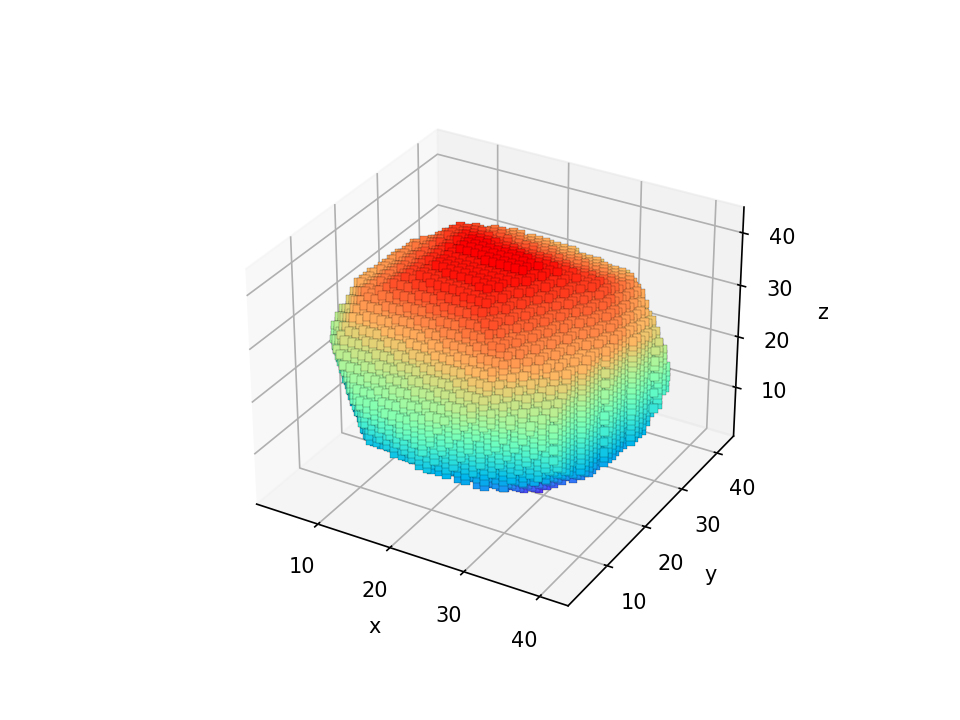

True
True


<IPython.core.display.Javascript object>


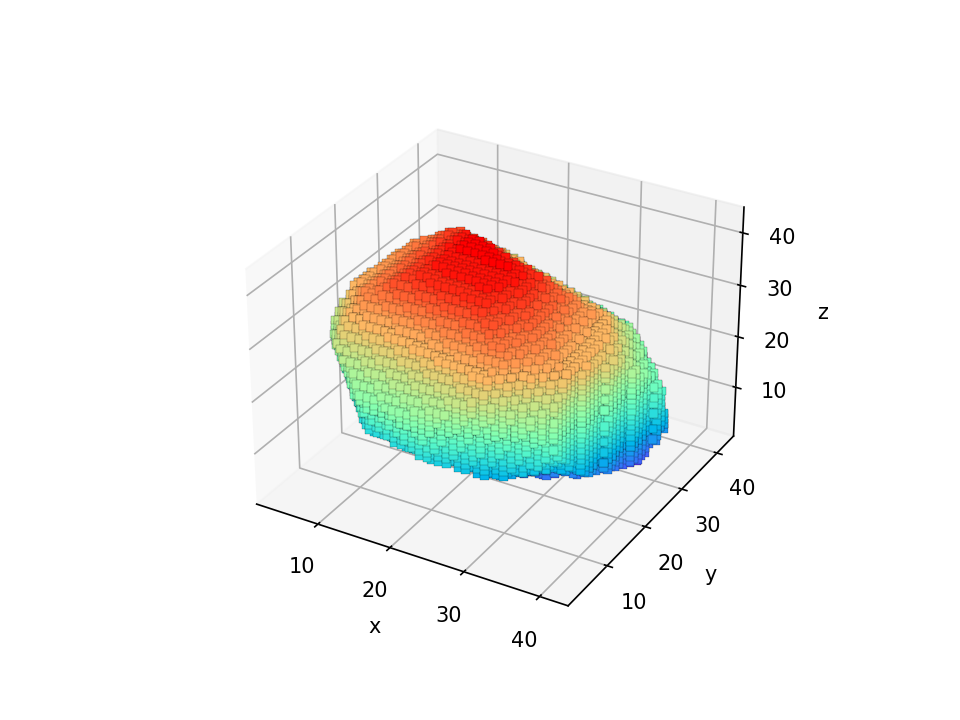

<IPython.core.display.Javascript object>


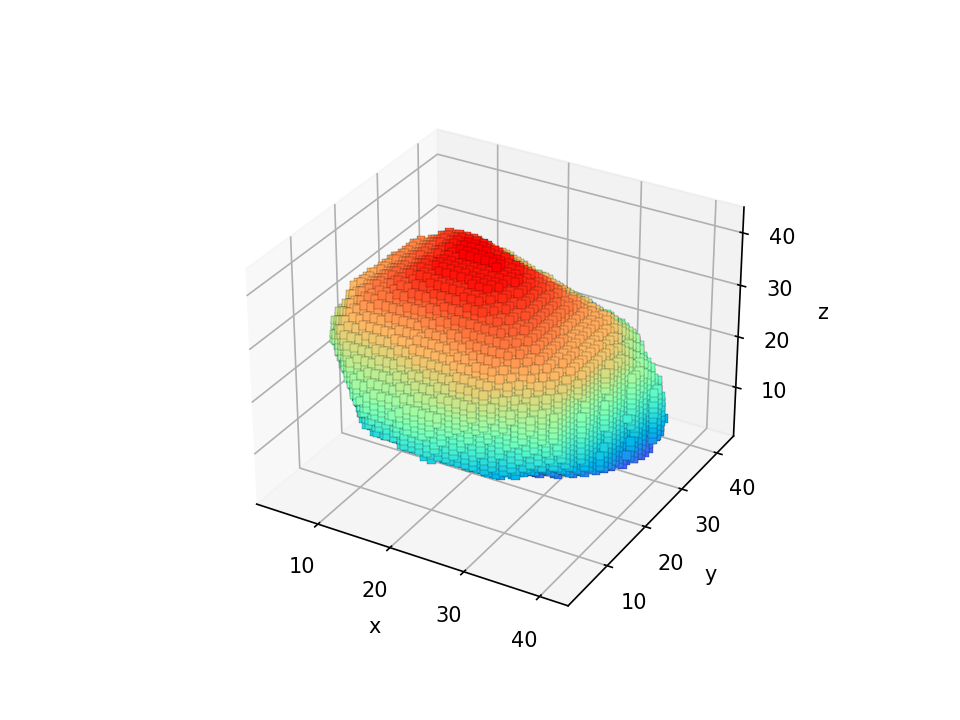

True


In [57]:
# Show a shape randomly selected from data/3DGeneratedForms/
# the deformation performed with it
# and the reconstruction of the spectrum computed with the deformation
for i in range(1):
    n = np.random.randint(136,261)
    #n = 153
    print(n)
    path = "data/3DGeneratedForms/form_"+str(n)+"_.npy"
    form = np.load(path)
    points = np.argwhere(form==True).astype(int)
    MF.show_shape(OBJ=points)
    
    print(test_bord(points,N))

    points = deformation(points)

    print(test_bord(points,N))

    MF.show_shape(OBJ=points)

    np.savetxt("tmp/tmp.txt",points,fmt="%s",delimiter=", ")

    form,N,b = MF.get_object_param("tmp/tmp.txt")

    RY = MF.extract_RY(big_RY,N,b)

    cr = MF.decompose(OBJ_PATH="tmp/tmp.txt",Lmax=Lmax,big_RY=big_RY,verbose=False)

    np.save("tmp/tmp",cr)

    shape = MF.recompose("tmp/tmp.npy",N=N,barycentre=b,RY=RY)[0]
    np.save("tmp/tmp",shape)

    MF.show_shape(PATH="tmp/tmp.npy")

    print(test_bord((np.argwhere(shape==True)),N))

In [14]:
# Generate nbShapes deformed shapes from those saved in data/3DGeneratedForms/
# and save them in data/AugmentedLPForms/
# The associated spectra are save in data/AugmentedLPSpectra/
# Note that we only choose here forms that where located in txt_angular (136<n<260) to have angular forms
nbShapes = 6000
with tqdm(total=nbShapes) as pbar:
    i = 1
    while i <= nbShapes:
        #n = np.random.randint(136,261)
        # n can be picked up randomly, or we can choose to computed the same number of deformed forms for 
        # each form in data/3DGeneratedForms/, see below
        # by doing this, we are less biased because each original form produces the same amount of deformed forms
        # but it is slower, because some forms generate deformed shapes that hardly fit in a N*N*N box
        n = 136+i%125
        path = "data/3DGeneratedForms/form_"+str(n)+"_.npy"
        form = np.load(path)
        points = np.argwhere(form==True).astype(int)
        
        test = test_bord(points,N)
        points = deformation(points)
        test = test and test_bord(points,N)

        if test:
            np.savetxt("tmp/tmp.txt",points,fmt="%s",delimiter=", ")

            form,N,b = MF.get_object_param("tmp/tmp.txt")

            RY = MF.extract_RY(big_RY,N,b)

            cr = MF.decompose(OBJ_PATH="tmp/tmp.txt",Lmax=Lmax,big_RY=big_RY,verbose=False)

            np.save("tmp/tmp",cr)

            shape = MF.recompose("tmp/tmp.npy",N=N,barycentre=b,RY=RY)[0]

            test = test and test_bord((np.argwhere(shape==True)),N)
            
            # We only save shapes that fit in a N*N*N box
            if test:
                i += 1
                np.save("data/AugmentedLPForms/form_"+str(i)+"_",points)
                np.save("data/AugmentedLPSpectra/spec_"+str(i)+"_",cr)
                pbar.update(1)

100%|████████████████████████████████████████████████████████████████████████████| 6000/6000 [2:46:18<00:00,  1.66s/it]
